# Time series clustering exercise

In [1]:
import pandas as pd
import zipfile 
import urllib
import requests
import os
import numpy as np
import geopandas as gp
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
import matplotlib.pyplot as plt
from sklearn import preprocessing
import scipy.cluster as scp
from sklearn.cluster import AgglomerativeClustering
%matplotlib inline

# Data

### 1. Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

### The data is on the github repo. Each file is the economic census for 1 year. 

In [2]:
# Download it programmatically and move it to PUIdata
mylist = ["94","95","96","97","98","99","00","01","02","03","04","05","06","07","08","09","10","11","12","13","14"]
for i in range(21):
    url =  "https://github.com/fedhere/PUI2018_fb55/blob/master/HW12_fb55/zbp{}totals.zip?raw=true".format(mylist[i])
    urllib.request.urlretrieve(url, os.getenv ('PUIDATA')+'/'+"zbp{}totals.zip".format(mylist[i]))

### 2. Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


In [3]:
url = " https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip"
urllib.request.urlretrieve(url, "fname.zip")
!unzip -d $PUIDATA fname.zip
!rm fname.zip

Archive:  fname.zip
  inflating: /nfshome/hl3282/PUIdata/ZIP_CODE_040114.shx  
  inflating: /nfshome/hl3282/PUIdata/ZIP_CODE_040114.dbf  
  inflating: /nfshome/hl3282/PUIdata/ZIP_CODE_040114.prj  
  inflating: /nfshome/hl3282/PUIdata/ZIP_CODE_040114.sbn  
  inflating: /nfshome/hl3282/PUIdata/ZIP_CODE_040114.sbx  
  inflating: /nfshome/hl3282/PUIdata/ZIP_CODE_040114.shp  
  inflating: /nfshome/hl3282/PUIdata/ZIP_CODE_040114.shp.xml  


In [4]:
nyczipsshp = gp.read_file(os.getenv("PUIDATA") + "/ZIP_CODE_040114.shp")
#nyczipsshp.plot()
#nyczipsshp.drop_duplicates("ZIPCODE").plot()
#nyczipsshp
print("ZIPCODES:",
      len(np.unique(nyczipsshp.ZIPCODE)), "POLYGONS:",
      len(nyczipsshp.ZIPCODE),
      "the difference is due to island with same zip as parts of land,",
      "but disjoint shapes")
nyczips = nyczipsshp.ZIPCODE.values.astype(int)
print("number of NYC zip codes:", len(nyczips))

ZIPCODES: 248 POLYGONS: 263 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 263


In [5]:
nyczipsshp = nyczipsshp[['ZIPCODE', 'geometry']]
nyczipsshp.sort_values('ZIPCODE', inplace=True)
nyczipsshp.head()

,ZIPCODE,geometry
54,00083,"POLYGON ((998309.7254775614 229616.6812362969,..."
82,10001,"POLYGON ((981958.6472873986 213464.4530421346,..."
92,10002,"POLYGON ((991339.8703228086 207576.7837151289,..."
90,10003,"POLYGON ((989830.469142139 207048.1263078749, ..."
113,10004,"POLYGON ((977542.4500830621 188447.2783390433,..."


In [6]:
nyczipsshp.rename(columns={'ZIPCODE':'ZIP'}, inplace=True)

In [7]:
nyczipsshp.ZIP = nyczipsshp.ZIP.astype(int)

In [8]:
nyczipsdf = nyczipsshp[['ZIP']]

## 3.You can use zipfile module in python to unzip the files
it should be installed in your system, but if it is not you can get the code with wget from here
https://github.com/python/cpython/blob/2.7/Lib/zipfile.py
remembering to use the raw link
(or you can use the usual shell commands)

In [9]:
## new dataframe including 21 year est data and zipcode
mylist = ["94", "95", "96", "97", "98", "99", "00", "01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14"]
for i in range(21):
    zf = zipfile.ZipFile(os.getenv ('PUIDATA')+'/'+"zbp{}totals.zip".format(mylist[i]))
    df = pd.read_csv(zf.open("zbp{}totals.zip".format(mylist[i]).replace('.zip','.txt')))
    df.columns = [column.upper() for column in df.columns]
    nyczipsdf = nyczipsdf.merge(df[df.ZIP.isin(nyczips)][['ZIP', 'EST']].rename(columns={'EST': 'EST%s'%mylist[i]}), how='left')
nyczipsdf.head()

,ZIP,EST94,EST95,EST96,EST97,EST98,EST99,EST00,EST01,EST02,...,EST05,EST06,EST07,EST08,EST09,EST10,EST11,EST12,EST13,EST14
0,83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001,6999.0,7088.0,7075.0,7154.0,7254.0,7233.0,7317.0,7188.0,7141.0,...,7312.0,7415.0,7549.0,7472.0,7305.0,7241.0,7227.0,7235.0,7273.0,7369.0
2,10002,1784.0,1819.0,1919.0,2049.0,2003.0,2085.0,2277.0,2543.0,2269.0,...,2682.0,2686.0,2685.0,2691.0,2775.0,2872.0,2912.0,2954.0,2988.0,2972.0
3,10003,3256.0,3377.0,3417.0,3535.0,3649.0,3659.0,3683.0,3602.0,3616.0,...,3867.0,3909.0,4049.0,4071.0,4099.0,4113.0,4159.0,4214.0,4277.0,4333.0
4,10004,1115.0,1124.0,1133.0,1173.0,1176.0,1233.0,1294.0,1247.0,1253.0,...,1260.0,1311.0,1370.0,1376.0,1379.0,1398.0,1404.0,1442.0,1479.0,1554.0


# 4. Data cleaning

you may need to clean your data: for some NYC zip codes there may be no info
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)


IMPORTANT: read the instructions below on pre-processing. Afte rthat:

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



## TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means
    in **a few** clusters (as discussed there is no real good, sound way to 
    decide what a good number is here. try a few options, keeping in mind 
    a few is more than a couple, but i recommand you stay within the 
    single digit numbers)
    
    3. plot the cluster centers (if you used K means those are the means of 
    the clusters). you can plot for example the cluster centers overlayed on 
    each time series (using the alpha channel to control the opacity in the 
    plot may be helpful here).
    
    4. Use another clustering algorithm (of your choice)
    
    5. overlay your data on a NYC map: you can use shapefiles for the 
    zip codes and different colors for different clusters
    
    6. Compare the results of the 2 algorithms
    
    7. attempt an interpretation. this is dangerous ground: clustering is 
    an exploratory tool so you do not want to jump to conclusions because 
    you see some clusters! but seeing structure in your data can inform 
    your next moves as an investigator. 
    

Note on preprocessing: the preparation of these data should include the "standardization" of the time seris. 
*Always when you apply a moachine learning model you should standardize the data or whiten it.*
These operations may be complicated preprocessing operation, they can for example invoke PCA, and they are aimed at removing covariance in the feature space.

The simplest version of whitening *standardizes each feature*" from every column (feature) you subtract the mean and you divide it by the standard deviation.

But the time series preprocessing is different if you want to use each time stamp as feature: because you want to maintain the coherence of the data, i.e. you **do not want** to treat each feature as an independent feature! the pattenrs in the time series are what you are clustering on (time series goes up and down, creating a pattern) and those patterns would be lost by whitening.

*So when you cluster or otherwise use a time series in a model, using each timestamp as a feature, you want to standardize the observations, not the features.* 

**From each row of your table (observation, in this case each zipcode) subtract the mean and you divide the row by the standard deviation.**

In [10]:
# 20 years of data and 263 zipcodes
nyczipsdf.iloc[:, 1:].shape

(263, 21)

In [11]:
#cleaning all missing values
cleancsb = nyczipsdf.iloc[:, 1:].dropna()
cleancsb.shape

(243, 21)

In [12]:
#then the standardization will look like:
vals = ((cleancsb.T - cleancsb.mean(1)) / cleancsb.std(1)).T

In [13]:
vals.head()

,EST94,EST95,EST96,EST97,EST98,EST99,EST00,EST01,EST02,EST03,...,EST05,EST06,EST07,EST08,EST09,EST10,EST11,EST12,EST13,EST14
1,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,0.432324,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986
2,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.522100,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077
3,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.127855,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833
4,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,-0.313478,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945
5,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,-0.313478,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945


vals.mean(axis=1) should return 0 (or something very small) everywhere

vals.mean(axis=1).shape should be (260,)

vals.std(axis=1) should return 1 everywhere

vals.std(axis=1).shape

In [14]:
vals.mean(axis=1)

1     -9.251859e-16
2      2.220446e-16
3     -5.286776e-17
4     -1.691768e-16
5     -1.691768e-16
6     -1.691768e-16
7     -1.691768e-16
8     -1.776357e-15
9      1.057355e-17
10    -5.498247e-16
11     1.586033e-16
12     2.960595e-16
13    -1.173664e-15
14     1.020348e-15
15     1.928021e-16
16    -4.335157e-16
17    -1.875484e-15
18    -8.353107e-16
19     1.374562e-15
20     7.137148e-16
21     6.396999e-16
22     3.277801e-16
23     1.215959e-15
24     1.533165e-15
25     0.000000e+00
26    -6.344132e-17
27     9.516197e-17
28    -2.326182e-16
29     9.529414e-16
30    -8.458842e-17
           ...     
233    2.008975e-16
234   -1.839798e-15
235   -6.132661e-16
236   -7.718693e-16
237    4.229421e-17
238    8.035900e-16
239   -5.286776e-17
240    5.286776e-17
241    3.383537e-16
242    8.670313e-16
243   -1.691768e-16
244   -2.114711e-17
245   -3.172066e-16
246   -5.392512e-16
247    4.440892e-16
248    3.674310e-16
249   -1.152517e-15
250    8.247371e-16
251   -6.449867e-16


In [15]:
vals.mean(axis=1).shape

(243,)

In [16]:
vals.std(axis=1)

1      1.0
2      1.0
3      1.0
4      1.0
5      1.0
6      1.0
7      1.0
8      1.0
9      1.0
10     1.0
11     1.0
12     1.0
13     1.0
14     1.0
15     1.0
16     1.0
17     1.0
18     1.0
19     1.0
20     1.0
21     1.0
22     1.0
23     1.0
24     1.0
25     1.0
26     1.0
27     1.0
28     1.0
29     1.0
30     1.0
      ... 
233    1.0
234    1.0
235    1.0
236    1.0
237    1.0
238    1.0
239    1.0
240    1.0
241    1.0
242    1.0
243    1.0
244    1.0
245    1.0
246    1.0
247    1.0
248    1.0
249    1.0
250    1.0
251    1.0
252    1.0
253    1.0
254    1.0
255    1.0
256    1.0
257    1.0
258    1.0
259    1.0
260    1.0
261    1.0
262    1.0
dtype: float64

In [17]:
vals.std(axis=1).shape

(243,)

## 5. cluster the NUMBER OF ESTABLISHMENTS time series with K-means

In [18]:
## This is one of method to determine the best k value, elbow method. This cell of code is from ADS.
def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

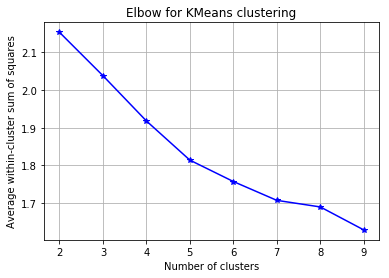

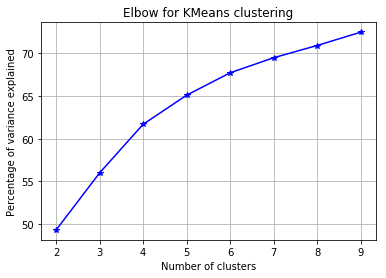

In [19]:
## but the professor recommands to stay within the single digit numbers
elbow(vals, range(2, 10))

## Figure 1: This is elbow plot to decide which k from 2 to 9 is best. However, the result is not obvious in the plot. I guess k=5 is better than the others to a certain extent.

In [20]:
nc = 5

In [21]:
#cluster with kmeans
km = KMeans(n_clusters=nc, random_state=444).fit(vals)

In [22]:
#each observation in the km object has a label: 
#that is the cluster assigned to that observation
km.labels_.shape
cluster = km.labels_
center = km.cluster_centers_

In [23]:
nyczipsdf_km = nyczipsdf.dropna()
nyczipsdf_km['km'] = pd.DataFrame(km.predict(vals), index= nyczipsdf_km.ZIP).reset_index()[[0]]
nyczipsdf_km = nyczipsdf.dropna()
nyczipsdf_km.iloc[:, 1:] = ((nyczipsdf_km.iloc[:, 1:].T - nyczipsdf_km.iloc[:, 1:].mean(1)) / 
    nyczipsdf_km.iloc[:, 1:].std(1)).T
nyczipsdf_km['cluster'] = cluster
nyczipsdf_km.head()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be s

,ZIP,EST94,EST95,EST96,EST97,EST98,EST99,EST00,EST01,EST02,...,EST06,EST07,EST08,EST09,EST10,EST11,EST12,EST13,EST14,cluster
1,10001,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,...,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986,0
2,10002,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,...,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077,0
3,10003,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,...,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833,3
4,10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,...,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,3
5,10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,...,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,3


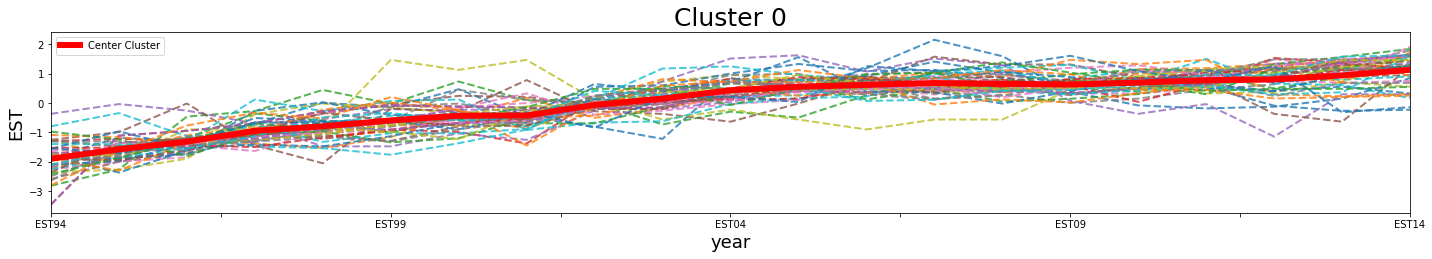

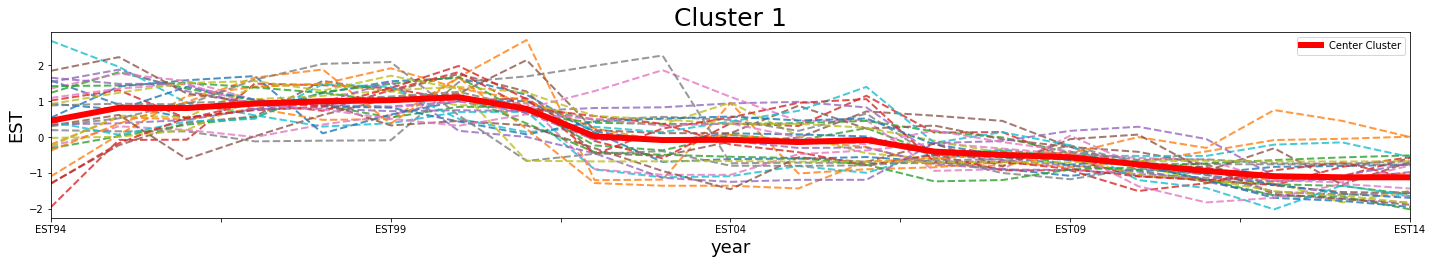

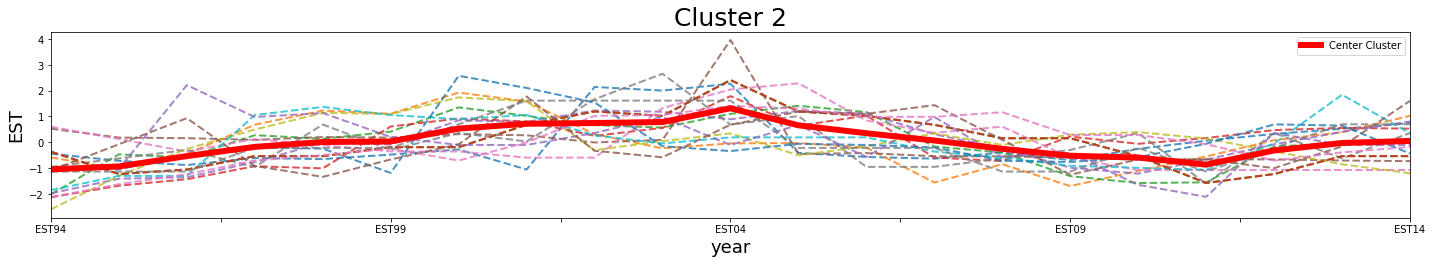

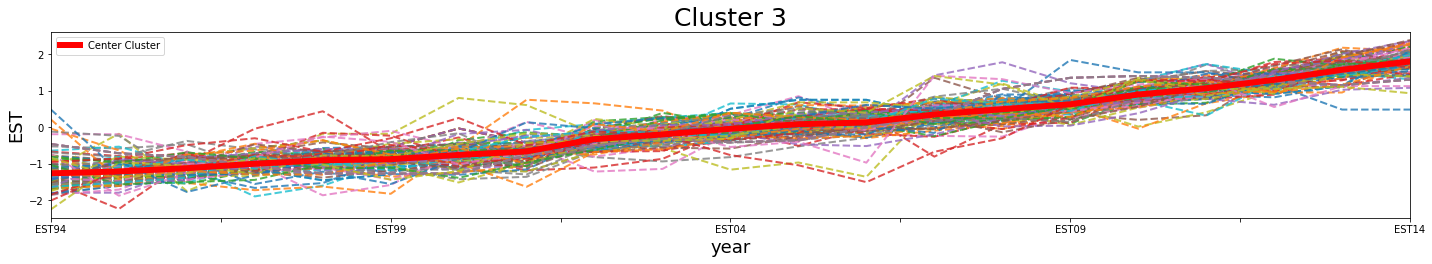

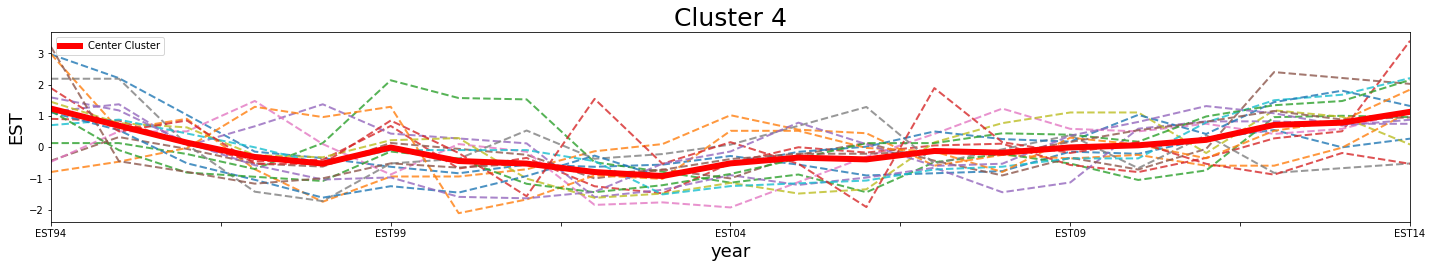

In [24]:
for i in range(0,5):
    fig = plt.figure(figsize=(20,16))
    ax = plt.subplot(5,1,i+1)
    nyczipsdf_kms = nyczipsdf_km[nyczipsdf_km['cluster']==i].iloc[:,1:-1]
    for j in range(nyczipsdf_kms.shape[0]):
        nyczipsdf_kms.iloc[j, :].plot(ax=ax, alpha=0.8, style='--', lw=2.0)
    pd.DataFrame(center[i]).rename(columns={0:"Center Cluster"}).plot(ax=ax, lw=6.0, color='Red', legend=True)
    ax.set_title('Cluster {}'.format(i),fontsize=25)
    ax.set_xlabel('year',fontsize=18)
    ax.set_ylabel('EST',fontsize=18)
    fig.tight_layout()
    plt.show()

### Figure 2: 5 plots of the cluster centers overlayed on each time series.  It is obvious that cluster0 and 3 has a increasing trend.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


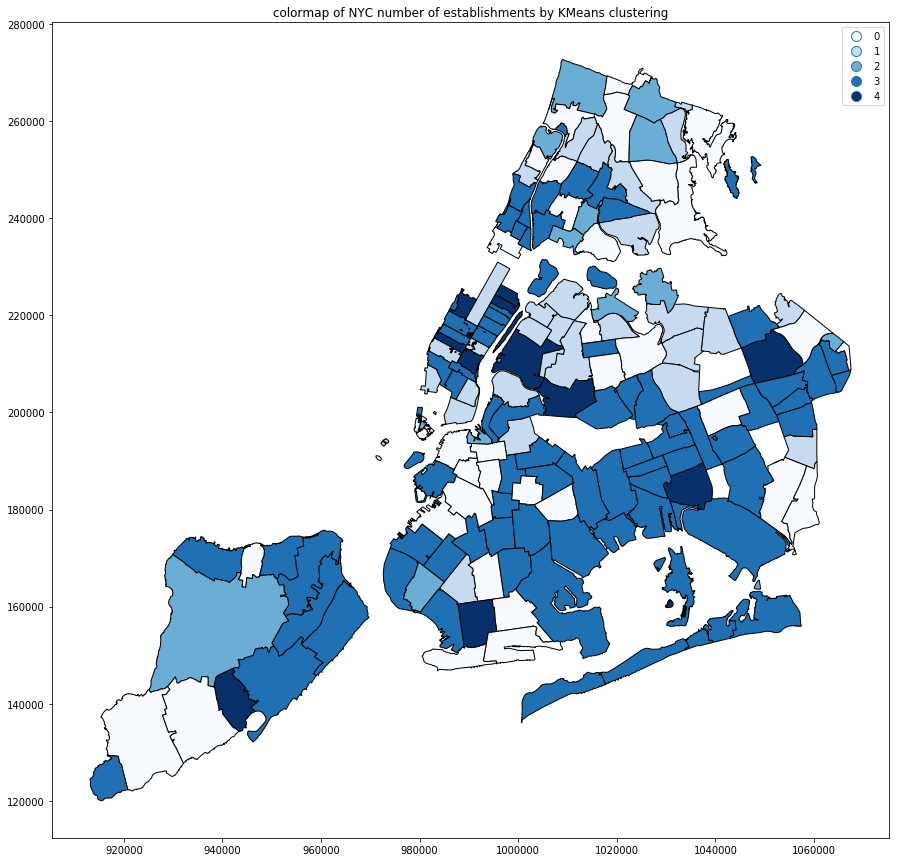

In [25]:
nyczipsdf_km_gd = nyczipsdf_km
nyczipsdf_km_gd['geometry'] = nyczipsshp['geometry']
geodata = gp.GeoDataFrame(nyczipsdf_km.copy())
geodata['labels'] = cluster
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
geodata.plot(column='labels', legend=True, categorical=True, cmap='Blues', figsize=(10,10), ax=ax, edgecolor='k')
plt.title('colormap of NYC number of establishments by KMeans clustering')
plt.show()

### Figure 3: cloropleth of cluster centers for 5 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top.

### 7 clusters

In [26]:
nc = 7

In [27]:
#cluster with kmeans
km = KMeans(n_clusters=nc, random_state=444).fit(vals)

In [28]:
#each observation in the km object has a label: 
#that is the cluster assigned to that observation
km.labels_.shape
cluster = km.labels_
center = km.cluster_centers_
cluster

array([2, 2, 0, 0, 0, 0, 0, 2, 6, 5, 2, 3, 2, 2, 3, 2, 5, 6, 0, 1, 5, 1, 1,
       2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 5, 0, 1, 0, 2, 2, 5, 0, 5,
       1, 5, 1, 4, 4, 6, 3, 6, 1, 2, 0, 1, 2, 4, 6, 6, 1, 2, 6, 1, 4, 4, 4,
       4, 5, 1, 1, 0, 4, 1, 3, 0, 6, 6, 0, 1, 6, 4, 6, 6, 3, 3, 3, 2, 6, 2,
       6, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 4, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 5, 5, 5, 0, 2, 0, 0, 0, 4, 4, 0, 2, 0, 0, 0, 2, 6, 0,
       2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2,
       0, 0, 0, 2, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 2, 0, 5, 2, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 2, 5, 2,
       2, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 2], dtype=int32)

In [29]:
nyczipsdf_km = nyczipsdf.dropna()
nyczipsdf_km['km'] = pd.DataFrame(km.predict(vals), index= nyczipsdf_km.ZIP).reset_index()[[0]]
nyczipsdf_km = nyczipsdf.dropna()
nyczipsdf_km.iloc[:, 1:] = ((nyczipsdf_km.iloc[:, 1:].T - nyczipsdf_km.iloc[:, 1:].mean(1)) / 
    nyczipsdf_km.iloc[:, 1:].std(1)).T
nyczipsdf_km['cluster'] = cluster
nyczipsdf_km.head()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be s

,ZIP,EST94,EST95,EST96,EST97,EST98,EST99,EST00,EST01,EST02,...,EST06,EST07,EST08,EST09,EST10,EST11,EST12,EST13,EST14,cluster
1,10001,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,...,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986,2
2,10002,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,...,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077,2
3,10003,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,...,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833,0
4,10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,...,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,0
5,10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,...,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,0


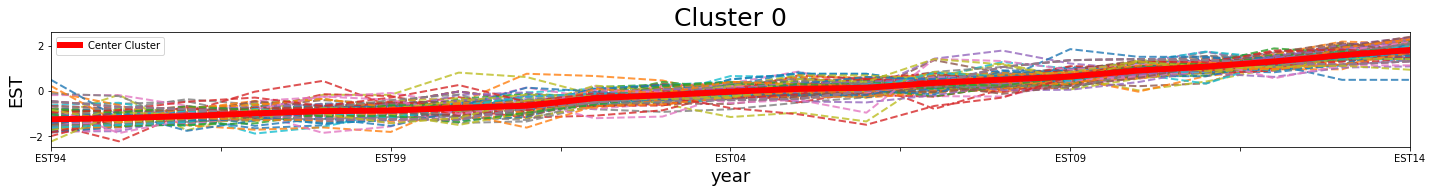

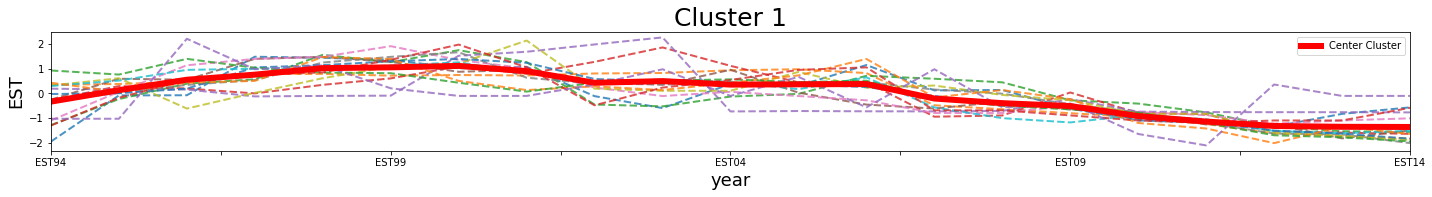

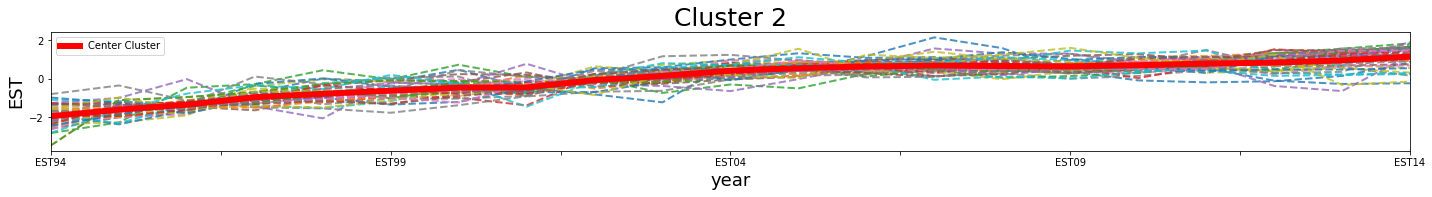

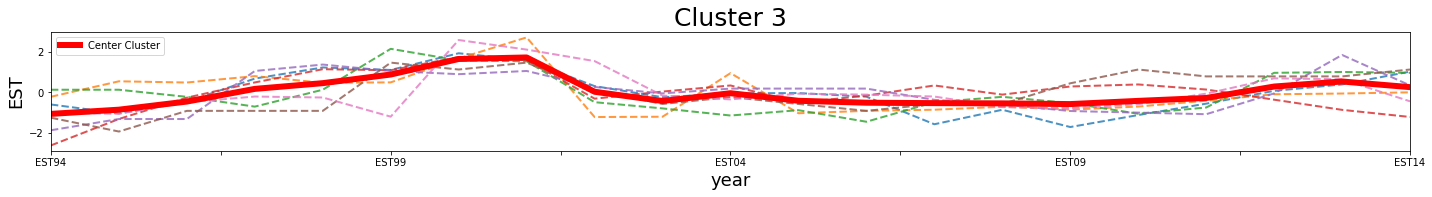

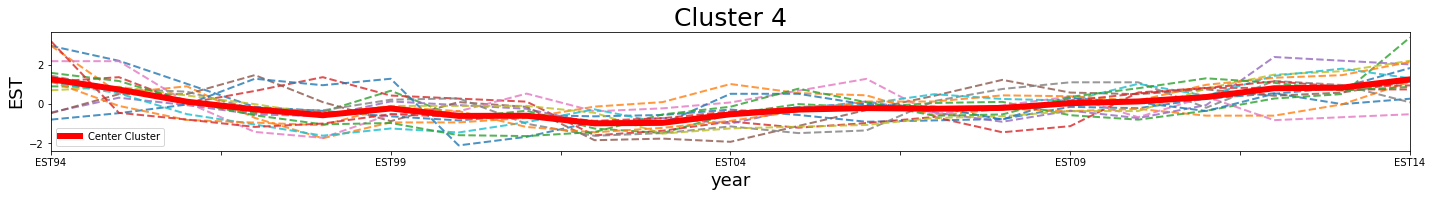

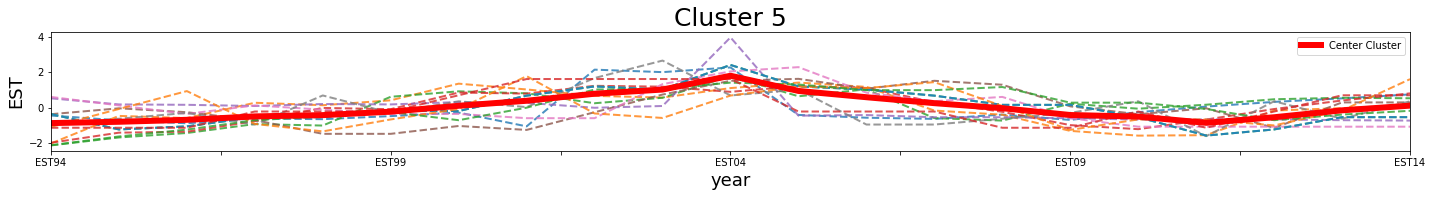

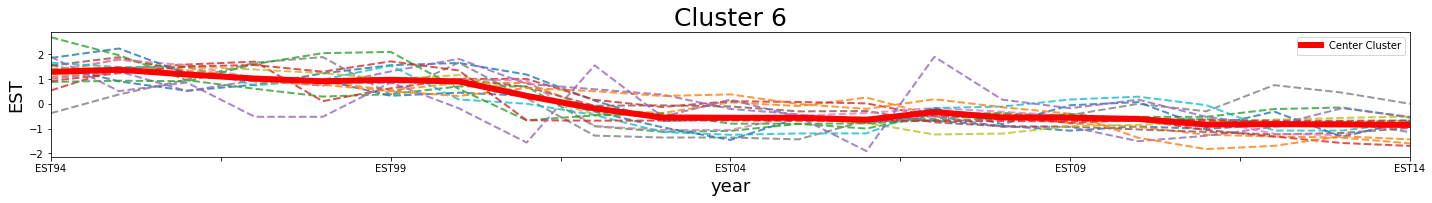

In [30]:
for i in range(0,7):
    fig = plt.figure(figsize=(20,16))
    ax = plt.subplot(7,1,i+1)
    nyczipsdf_kms = nyczipsdf_km[nyczipsdf_km['cluster']==i].iloc[:,1:-1]
    for j in range(nyczipsdf_kms.shape[0]):
        nyczipsdf_kms.iloc[j, :].plot(ax=ax, alpha=0.8, style='--', lw=2.0)
    pd.DataFrame(center[i]).rename(columns={0:"Center Cluster"}).plot(ax=ax, lw=6.0, color='Red', legend=True)
    ax.set_title('Cluster {}'.format(i),fontsize=25)
    ax.set_xlabel('year',fontsize=18)
    ax.set_ylabel('EST',fontsize=18)
    fig.tight_layout()
    plt.show()

### Figure 4: 7 plots of the cluster centers overlayed on each time series. It is obvious that cluster0 and 2 have a increasing trend.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


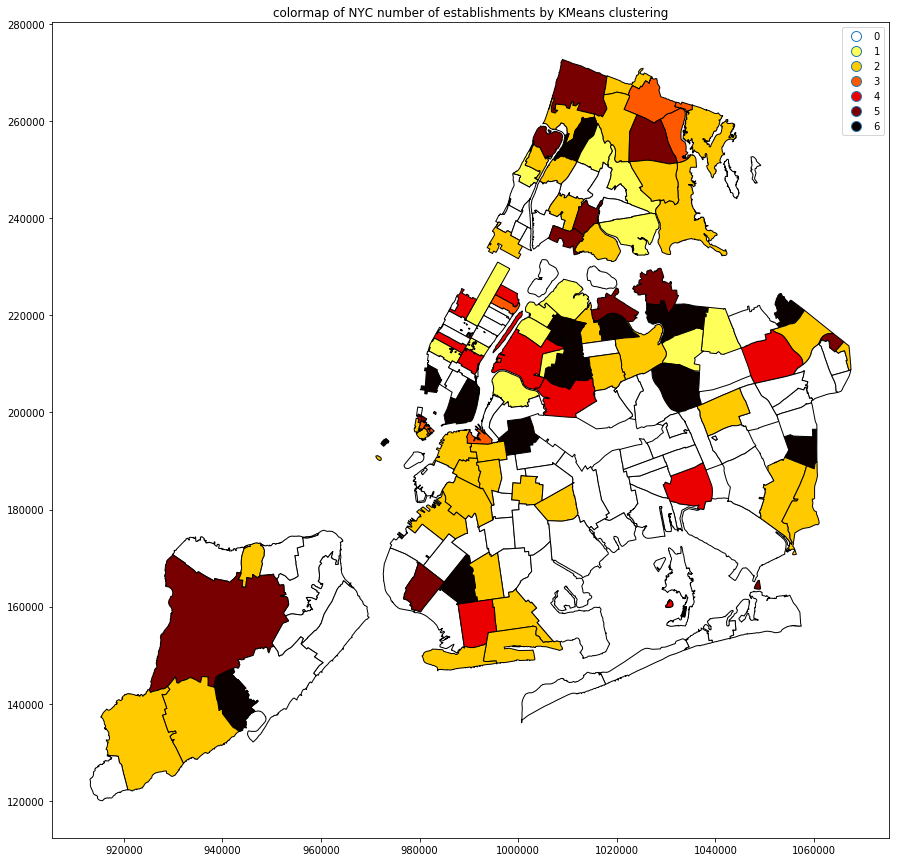

In [31]:
nyczipsdf_km_gd = nyczipsdf_km
nyczipsdf_km_gd['geometry'] = nyczipsshp['geometry']
geodata = gp.GeoDataFrame(nyczipsdf_km.copy())
geodata['labels'] = cluster
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
geodata.plot(column='labels', legend=True, categorical=True, cmap='hot_r', figsize=(10,10), ax=ax, edgecolor='k')
plt.title('colormap of NYC number of establishments by KMeans clustering')
plt.show()

### Figure 5: cloropleth of cluster centers for 7 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top.

### or maybe like this, depending on which algorithm you use, and how you proceed to preprocess your data and how you cluster it. There is no one correct answer, but general trends should be retrieved.

### Agglomerative Clustering

### 5 clusters

In [32]:
agc = AgglomerativeClustering(n_clusters=5, linkage='average').fit(vals)
centroidsag = np.zeros((5, vals.shape[1]))

In [33]:
cluster = agc.labels_
cluster

array([2, 2, 2, 2, 2, 2, 2, 2, 3, 0, 2, 0, 2, 2, 4, 2, 0, 3, 2, 3, 0, 3, 3,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 3, 2, 2, 2, 0, 2, 0,
       0, 0, 3, 1, 1, 3, 4, 3, 3, 2, 2, 3, 2, 2, 3, 3, 3, 2, 3, 3, 4, 2, 4,
       1, 0, 3, 3, 2, 4, 3, 0, 2, 4, 3, 2, 3, 3, 2, 3, 3, 0, 2, 0, 2, 3, 2,
       3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2])

In [34]:
nyczipsdf_agc = nyczipsdf.dropna()
nyczipsdf_agc.iloc[:, 1:] = ((nyczipsdf_agc.iloc[:, 1:].T - nyczipsdf_agc.iloc[:, 1:].mean(1)) / 
    nyczipsdf_agc.iloc[:, 1:].std(1)).T
nyczipsdf_agc['cluster'] = cluster
nyczipsdf_agc.head()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ZIP,EST94,EST95,EST96,EST97,EST98,EST99,EST00,EST01,EST02,...,EST06,EST07,EST08,EST09,EST10,EST11,EST12,EST13,EST14,cluster
1,10001,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,...,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986,2
2,10002,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,...,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077,2
3,10003,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,...,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833,2
4,10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,...,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,2
5,10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,...,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,2


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


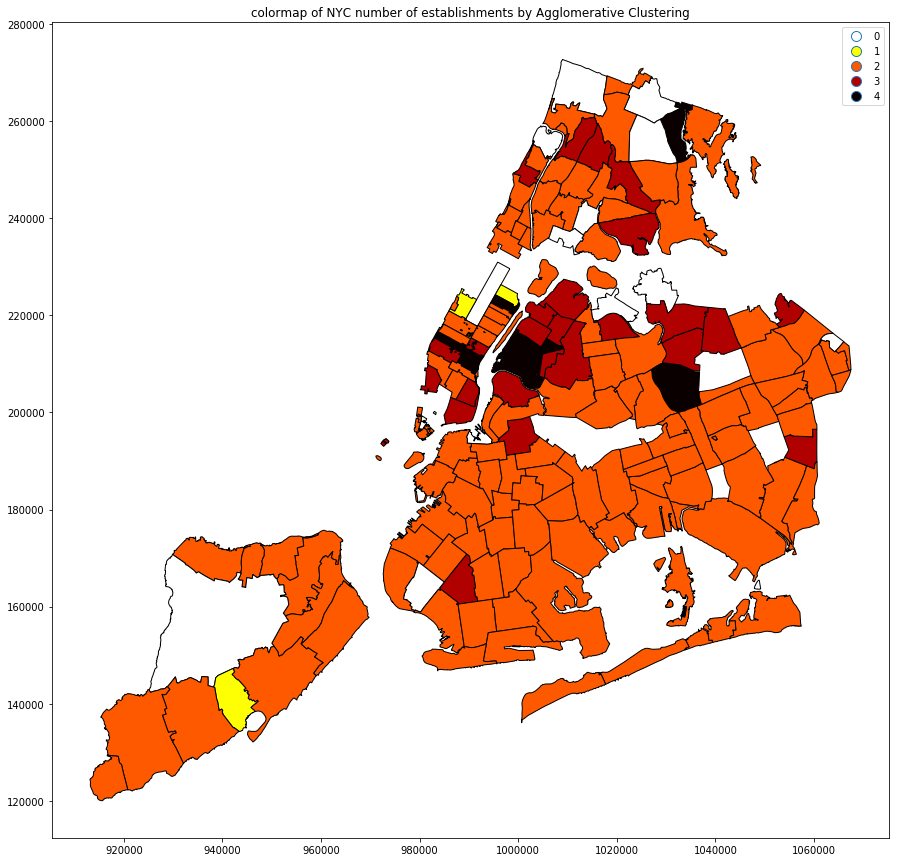

In [35]:
nyczipsdf_agc_gd = nyczipsdf_agc
nyczipsdf_agc_gd['geometry'] = nyczipsshp['geometry']
geodata = gp.GeoDataFrame(nyczipsdf_agc_gd.copy())
geodata['labels'] = cluster
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
geodata.plot(column='labels', legend=True, categorical=True, cmap='hot_r', figsize=(10,10), ax=ax, edgecolor='k')
plt.title('colormap of NYC number of establishments by Agglomerative Clustering')
plt.show()

### Figure 6: cloropleth of cluster centers for 5 Agglomerative Clustering clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top.

### 7 clusters

In [36]:
agc = AgglomerativeClustering(n_clusters=7, linkage='average').fit(vals)
centroidsag = np.zeros((7, vals.shape[1]))

In [37]:
cluster = agc.labels_
cluster

array([2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 2, 6, 2, 2, 4, 2, 6, 1, 2, 1, 6, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 1, 2, 2, 2, 3, 2, 3,
       6, 3, 1, 0, 0, 1, 4, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 4, 2, 4,
       0, 3, 1, 1, 2, 4, 1, 6, 2, 4, 1, 2, 1, 1, 2, 1, 1, 6, 2, 6, 2, 1, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2])

In [38]:
nyczipsdf_agc = nyczipsdf.dropna()
nyczipsdf_agc.iloc[:, 1:] = ((nyczipsdf_agc.iloc[:, 1:].T - nyczipsdf_agc.iloc[:, 1:].mean(1)) / 
    nyczipsdf_agc.iloc[:, 1:].std(1)).T
nyczipsdf_agc['cluster'] = cluster
nyczipsdf_agc.head()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ZIP,EST94,EST95,EST96,EST97,EST98,EST99,EST00,EST01,EST02,...,EST06,EST07,EST08,EST09,EST10,EST11,EST12,EST13,EST14,cluster
1,10001,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,...,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986,2
2,10002,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,...,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077,2
3,10003,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,...,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833,2
4,10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,...,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,2
5,10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,...,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,2


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


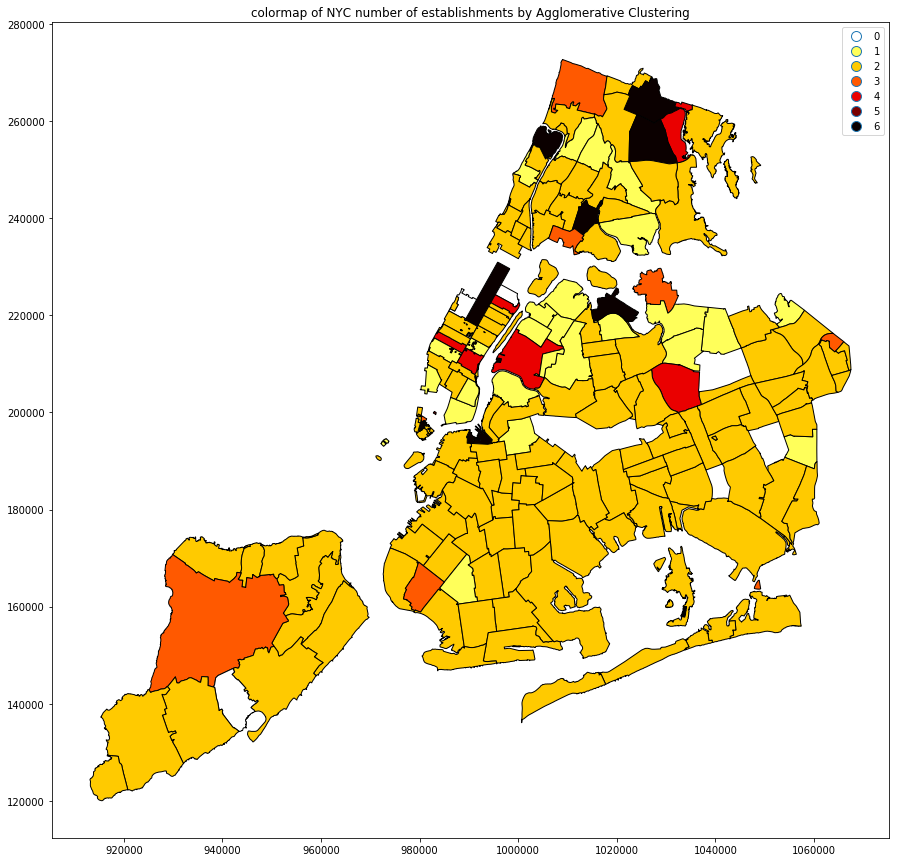

In [39]:
nyczipsdf_agc_gd = nyczipsdf_agc
nyczipsdf_agc_gd['geometry'] = nyczipsshp['geometry']
geodata = gp.GeoDataFrame(nyczipsdf_agc_gd.copy())
geodata['labels'] = cluster
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
geodata.plot(column='labels', legend=True, categorical=True, cmap='hot_r', figsize=(10,10), ax=ax, edgecolor='k')
plt.title('colormap of NYC number of establishments by Agglomerative Clustering')
plt.show()

### Figure 7: cloropleth of cluster centers for 7 Agglomerative Clustering clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top.

### Compare the results of the 2 algorithms and interpretation
### KMeans Clustering and Agglomerative Clustering's result are very similar from the colormap. However, KMeans are not stable from 5 clusters to 7 clusters and Agglomerative Clustering is stable compared to KMeans. From the other perspective, Agglomerative Clustering is more smooth. And there are some clustering differences in specific areas between two clustering methods, such as manhattan.

### And if you use hierarchical clustering in scipy you can make a dandrogram it may look like this:

### Hierarchical Clustering

(array([   5,   15,   25,   35,   45,   55,   65,   75,   85,   95,  105,
         115,  125,  135,  145,  155,  165,  175,  185,  195,  205,  215,
         225,  235,  245,  255,  265,  275,  285,  295,  305,  315,  325,
         335,  345,  355,  365,  375,  385,  395,  405,  415,  425,  435,
         445,  455,  465,  475,  485,  495,  505,  515,  525,  535,  545,
         555,  565,  575,  585,  595,  605,  615,  625,  635,  645,  655,
         665,  675,  685,  695,  705,  715,  725,  735,  745,  755,  765,
         775,  785,  795,  805,  815,  825,  835,  845,  855,  865,  875,
         885,  895,  905,  915,  925,  935,  945,  955,  965,  975,  985,
         995, 1005, 1015, 1025, 1035, 1045, 1055, 1065, 1075, 1085, 1095,
        1105, 1115, 1125, 1135, 1145, 1155, 1165, 1175, 1185, 1195, 1205,
        1215, 1225, 1235, 1245, 1255, 1265, 1275, 1285, 1295, 1305, 1315,
        1325, 1335, 1345, 1355, 1365, 1375, 1385, 1395, 1405, 1415, 1425,
        1435, 1445, 1455, 1465, 1475, 

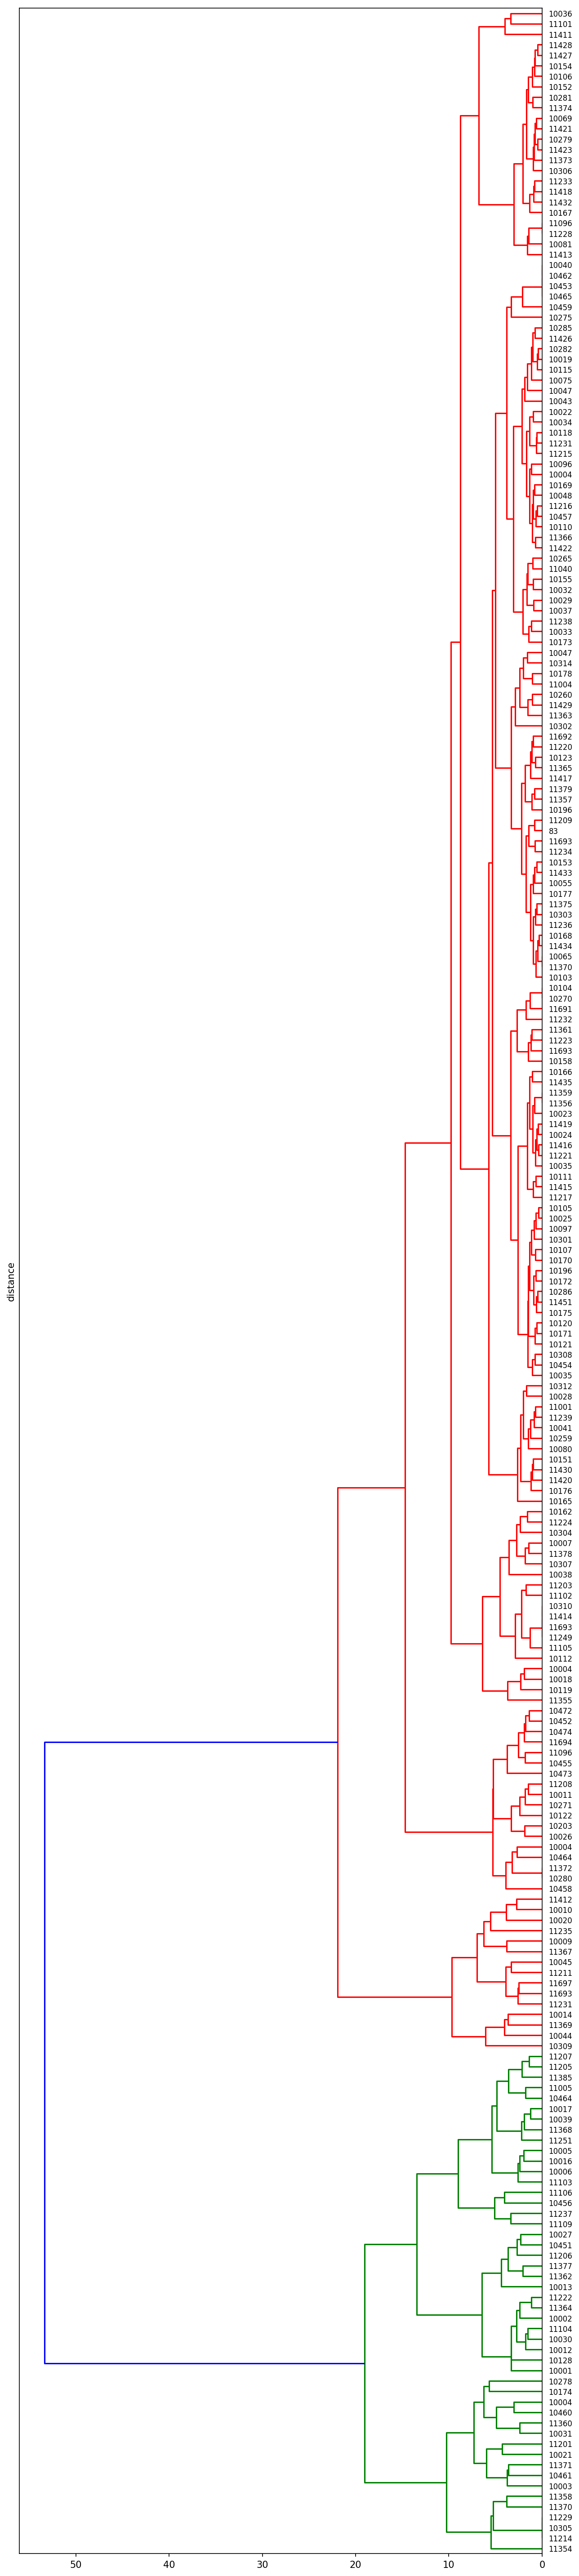

In [40]:
import scipy.cluster as scp
fig = plt.figure(figsize=(10,50), dpi=150)
plt.ylabel("distance")
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(vals, method='ward'),
                               labels = nyczips,
                               leaf_rotation=90.,  # rotates the x axis labels
                               leaf_font_size=8.,
                               orientation='left')
# font size for the x axis labels
plt.yticks(rotation=0)

### Figure 8: It is a dandrogram of hierarchical clustering with zipcode labels, eucledian distance in lat-lon space, and ward linkage using minimum variance method.

In [42]:
!pwd

/nfshome/hl3282/PUI/HW12_hl3282
